<a href="https://colab.research.google.com/github/vin123k/RL_116/blob/main/BabyRobot_Part4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# UCB Implementation

In [24]:
import random
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.core.pylabtools import figsize

import os
if not os.path.exists("Images"):
  os.makedirs("Images")

"""
    System Setup
"""

# create 5 sockets in a fixed order
socket_order = [2,1,3,5,4]

# the true values of each socket
socket_means = [((q*2)+2) for q in socket_order]

# save the number of sockets
NUM_SOCKETS = len(socket_order)


"""
    Display Setup
"""

# display all floating point numbers to 3 decimal places
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})


"""
    Helper Functions
"""

# return the index of the largest value in the supplied list
# - arbitrarily select between the largest values in the case of a tie
# (the standard np.argmax just chooses the first value in the case of a tie)
def random_argmax(value_list):
  """ a random tie-breaking argmax"""
  values = np.asarray(value_list)
  return np.argmax(np.random.random(values.shape) * (values==values.max()))



class PowerSocket:
    """ the base power socket class """

    def __init__(self, q):
        self.q = q        # the true reward value
        self.initialize() # reset the socket

    def initialize(self):
        self.Q = 0   # the estimate of this socket's reward value
        self.n = 0   # the number of times this socket has been tried

    def charge(self):
        """ return a random amount of charge """

        # the reward is a guassian distribution with unit variance around the true
        # value 'q'
        value = np.random.randn() + self.q

        # never allow a charge less than 0 to be returned
        return 0 if value < 0 else value

    def update(self,R):
        """ update this socket after it has returned reward value 'R' """

        # increment the number of times this socket has been tried
        self.n += 1

        # the new estimate of the mean is calculated from the old estimate
        self.Q = (1 - 1.0/self.n) * self.Q + (1.0/self.n) * R

    def sample(self,t):
        """ return an estimate of the socket's reward value """
        return self.Q



class SocketTester():
    """ create and test a set of sockets over a single test run """

    def __init__(self, socket=PowerSocket, socket_order=socket_order, multiplier=2, **kwargs ):

        # create supplied socket type with a mean value defined by socket order
        self.sockets = [socket((q*multiplier)+2, **kwargs) for q in socket_order]

        # set the number of sockets equal to the number created
        self.number_of_sockets = len(self.sockets)

        # the index of the best socket is the last in the socket_order list
        # - this is a one-based value so convert to zero-based
        self.optimal_socket_index = (socket_order[-1] - 1)

        # by default a socket tester records 2 bits of information over a run
        self.number_of_stats = kwargs.pop('number_of_stats', 2)


    def initialize_run(self, number_of_steps):
        """ reset counters at the start of a run """

        # save the number of steps over which the run will take place
        self.number_of_steps = number_of_steps

        # reset the actual number of steps that the test ran for
        self.total_steps = 0

        # monitor the total reward obtained over the run
        self.total_reward = 0

        # the current total reward at each timestep of the run
        self.total_reward_per_timestep = []

        # the actual reward obtained at each timestep
        self.reward_per_timestep = []

        # stats for each time-step
        # - by default records: estimate, number of trials
        self.socket_stats = np.zeros(shape=(number_of_steps+1,
                                            self.number_of_sockets,
                                            self.number_of_stats))

        # ensure that all sockets are re-initialized
        for socket in self.sockets: socket.initialize()


    def charge_and_update(self,socket_index):
        """ charge from & update the specified socket and associated parameters """

        # charge from the chosen socket and update its mean reward value
        reward = self.sockets[socket_index].charge()
        self.sockets[socket_index].update(reward)

        # update the total reward
        self.total_reward += reward

        # store the current total reward at this timestep
        self.total_reward_per_timestep.append(self.total_reward)

        # store the reward obtained at this timestep
        self.reward_per_timestep.append(reward)


    def get_socket_stats( self, t ):
        """ get the current information from each socket """
        socket_stats = [[socket.Q, socket.n] for socket in self.sockets]
        return socket_stats

    def get_mean_reward( self ):
        """ the total reward averaged over the number of time steps """
        return (self.total_reward/self.total_steps)

    def get_total_reward_per_timestep( self ):
        """ the cumulative total reward at each timestep of the run """
        return self.total_reward_per_timestep

    def get_reward_per_timestep( self ):
        """ the actual reward obtained at each timestep of the run """
        return self.reward_per_timestep

    def get_estimates(self):
        """ get the estimate of each socket's reward at each timestep of the run """
        return self.socket_stats[:,:,0]

    def get_number_of_trials(self):
        """ get the number of trials of each socket at each timestep of the run """
        return self.socket_stats[:,:,1]

    def get_socket_percentages( self ):
        """ get the percentage of times each socket was tried over the run """
        return (self.socket_stats[:,:,1][self.total_steps]/self.total_steps)

    def get_optimal_socket_percentage( self ):
        """ get the percentage of times the optimal socket was tried """
        final_trials = self.socket_stats[:,:,1][self.total_steps]
        return (final_trials[self.optimal_socket_index]/self.total_steps)

    def get_time_steps( self ):
        """ get the number of time steps that the test ran for """
        return self.total_steps


    def select_socket( self, t ):
        """ Greedy Socket Selection"""

        # choose the socket with the current highest mean reward or arbitrarily
        # select a socket in the case of a tie
        socket_index = random_argmax([socket.sample(t+1) for socket in self.sockets])
        return socket_index


    def run( self, number_of_steps, maximum_total_reward = float('inf')):
        """ perform a single run, over the set of sockets,
            for the defined number of steps """

        # reset the run counters
        self.initialize_run(number_of_steps)

        # loop for the specified number of time-steps
        for t in range(number_of_steps):

            # get information about all sockets at the start of the time step
            self.socket_stats[t] = self.get_socket_stats(t)

            # select a socket
            socket_index = self.select_socket(t)

            # charge from the chosen socket and update its mean reward value
            self.charge_and_update(socket_index)

            # test if the accumulated total reward is greater than the maximum
            if self.total_reward > maximum_total_reward:
                break

        # save the actual number of steps that have been run
        self.total_steps = t

        # get the stats for each socket at the end of the run
        self.socket_stats[t+1] = self.get_socket_stats(t+1)

        return self.total_steps, self.total_reward


class SocketExperiment():
    """ setup and run repeated socket tests to get the average results """

    def __init__(self,
                 socket_tester = SocketTester,
                 number_of_tests = 1000,
                 number_of_steps = 30,
                 maximum_total_reward = float('inf'),
                 **kwargs ):

        self.socket_tester = socket_tester
        self.number_of_tests = number_of_tests
        self.number_of_steps = number_of_steps
        self.maximum_total_reward = maximum_total_reward
        self.number_of_sockets = self.socket_tester.number_of_sockets

    def initialize_run(self):

        # keep track of the average values over the run
        self.mean_total_reward = 0.
        self.optimal_selected = 0.
        self.mean_time_steps = 0.
        self.socket_percentages = np.zeros(self.number_of_sockets)
        self.estimates = np.zeros(shape=(self.number_of_steps+1,self.number_of_sockets))
        self.number_of_trials = np.zeros(shape=(self.number_of_steps+1,self.number_of_sockets))

        # the cumulative total reward per timestep
        self.cumulative_reward_per_timestep = np.zeros(shape=(self.number_of_steps))

        # the actual reward obtained at each timestep
        self.reward_per_timestep = np.zeros(shape=(self.number_of_steps))

    def get_mean_total_reward(self):
        """ the final total reward averaged over the number of timesteps """
        return self.mean_total_reward

    def get_cumulative_reward_per_timestep(self):
        """ the cumulative total reward per timestep """
        return self.cumulative_reward_per_timestep

    def get_reward_per_timestep(self):
        """ the mean actual reward obtained at each timestep """
        return self.reward_per_timestep

    def get_optimal_selected(self):
        """ the mean times the optimal socket was selected """
        return self.optimal_selected

    def get_socket_percentages(self):
        """ the mean of the percentage times each socket was selected """
        return self.socket_percentages

    def get_estimates(self):
        """ per socket reward estimates """
        return self.estimates

    def get_number_of_trials(self):
        """ per socket number of trials """
        return self.number_of_trials

    def get_mean_time_steps(self):
        """ the average number of trials of each test """
        return self.mean_time_steps

    def update_mean( self, current_mean, new_value, n ):
        """ calculate the new mean from the previous mean and the new value """
        return (1 - 1.0/n) * current_mean + (1.0/n) * new_value

    def update_mean_array( self, current_mean, new_value, n ):
        """ calculate the new mean from the previous mean and the new value for an array """

        new_value = np.array(new_value)

        # pad the new array with its last value to make sure its the same length as the original
        pad_length = (current_mean.shape[0] - new_value.shape[0])

        if pad_length > 0:
            new_array = np.pad(new_value,(0,pad_length), mode='constant', constant_values=new_value[-1])
        else:
            new_array = new_value

        return (1 - 1.0/n) * current_mean + (1.0/n) * new_array

    def record_test_stats(self,n):
        """ update the mean value for each statistic being tracked over a run """

        # calculate the new means from the old means and the new value
        tester = self.socket_tester
        self.mean_total_reward = self.update_mean( self.mean_total_reward, tester.get_mean_reward(), n)
        self.optimal_selected = self.update_mean( self.optimal_selected, tester.get_optimal_socket_percentage(), n)
        self.socket_percentages = self.update_mean( self.socket_percentages, tester.get_socket_percentages(), n)
        self.mean_time_steps = self.update_mean( self.mean_time_steps, tester.get_time_steps(), n)

        self.cumulative_reward_per_timestep = self.update_mean_array( self.cumulative_reward_per_timestep,
                                                                      tester.get_total_reward_per_timestep(), n)

        # check if the tests are only running until a maximum reward value is reached
        if self.maximum_total_reward == float('inf'):

            self.estimates = self.update_mean_array( self.estimates, tester.get_estimates(), n)
            self.cumulative_reward_per_timestep = self.update_mean_array( self.cumulative_reward_per_timestep,
                                                                          tester.get_total_reward_per_timestep(), n)
            self.reward_per_timestep = self.update_mean_array( self.reward_per_timestep, tester.get_reward_per_timestep(), n)
            self.number_of_trials = self.update_mean_array( self.number_of_trials, tester.get_number_of_trials(), n)

    def run(self):
        """ repeat the test over a set of sockets for the specified number of trials """

        # do the specified number of runs for a single test
        self.initialize_run()
        for n in range(1,self.number_of_tests+1):

            # do one run of the test
            self.socket_tester.run( self.number_of_steps, self.maximum_total_reward )
            self.record_test_stats(n)

## UCB Implementation

In [25]:
class UCBSocket( PowerSocket ):

    def __init__( self, q, **kwargs ):
        """ initialize the UCB socket """

        # store the confidence level controlling exploration
        self.confidence_level = kwargs.pop('confidence_level', 2.0)

        # pass the true reward value to the base PowerSocket
        super().__init__(q)

    def uncertainty(self, t):
        """ calculate the uncertainty in the estimate of this socket's mean """
        if self.n == 0: return float('inf')
        return self.confidence_level * (np.sqrt(np.log(t) / self.n))

    def sample(self,t):
        """ the UCB reward is the estimate of the mean reward plus its uncertainty """
        return self.Q + self.uncertainty(t)

In [26]:
class UCBSocketTester( SocketTester ):

    def __init__(self, socket_order=socket_order, confidence_level=2.0 ):
        """ initialize the socket tester """
        super().__init__(socket = UCBSocket,
                         socket_order = socket_order,
                         confidence_level = confidence_level,
                         number_of_stats = 3) # a UCB socket tester records 3 bits of information over a run

    def get_socket_stats( self, t ):
        """ record the current values of each socket """
        socket_stats = [[socket.Q,socket.n,socket.uncertainty(t+1)] for socket in self.sockets]
        return socket_stats

    def select_socket( self, t ):
        """ choose the socket with the current highest UCB reward """
        socket_index = random_argmax([socket.sample(t+1) for socket in self.sockets])
        return socket_index

## Analysis of UCB

In [27]:
# do a single run with only 2 sockets to examine how the exploration and exploitation terms of the UCB equation vary
number_of_sockets = 2
number_of_steps = 20

# set the random seed to produce a recreatable graph
random.seed(0)
np.random.seed(0)

tester = UCBSocketTester( socket_order[:number_of_sockets], confidence_level = 3.0 )
tester.run( number_of_steps )

(19, 114.77150488946722)

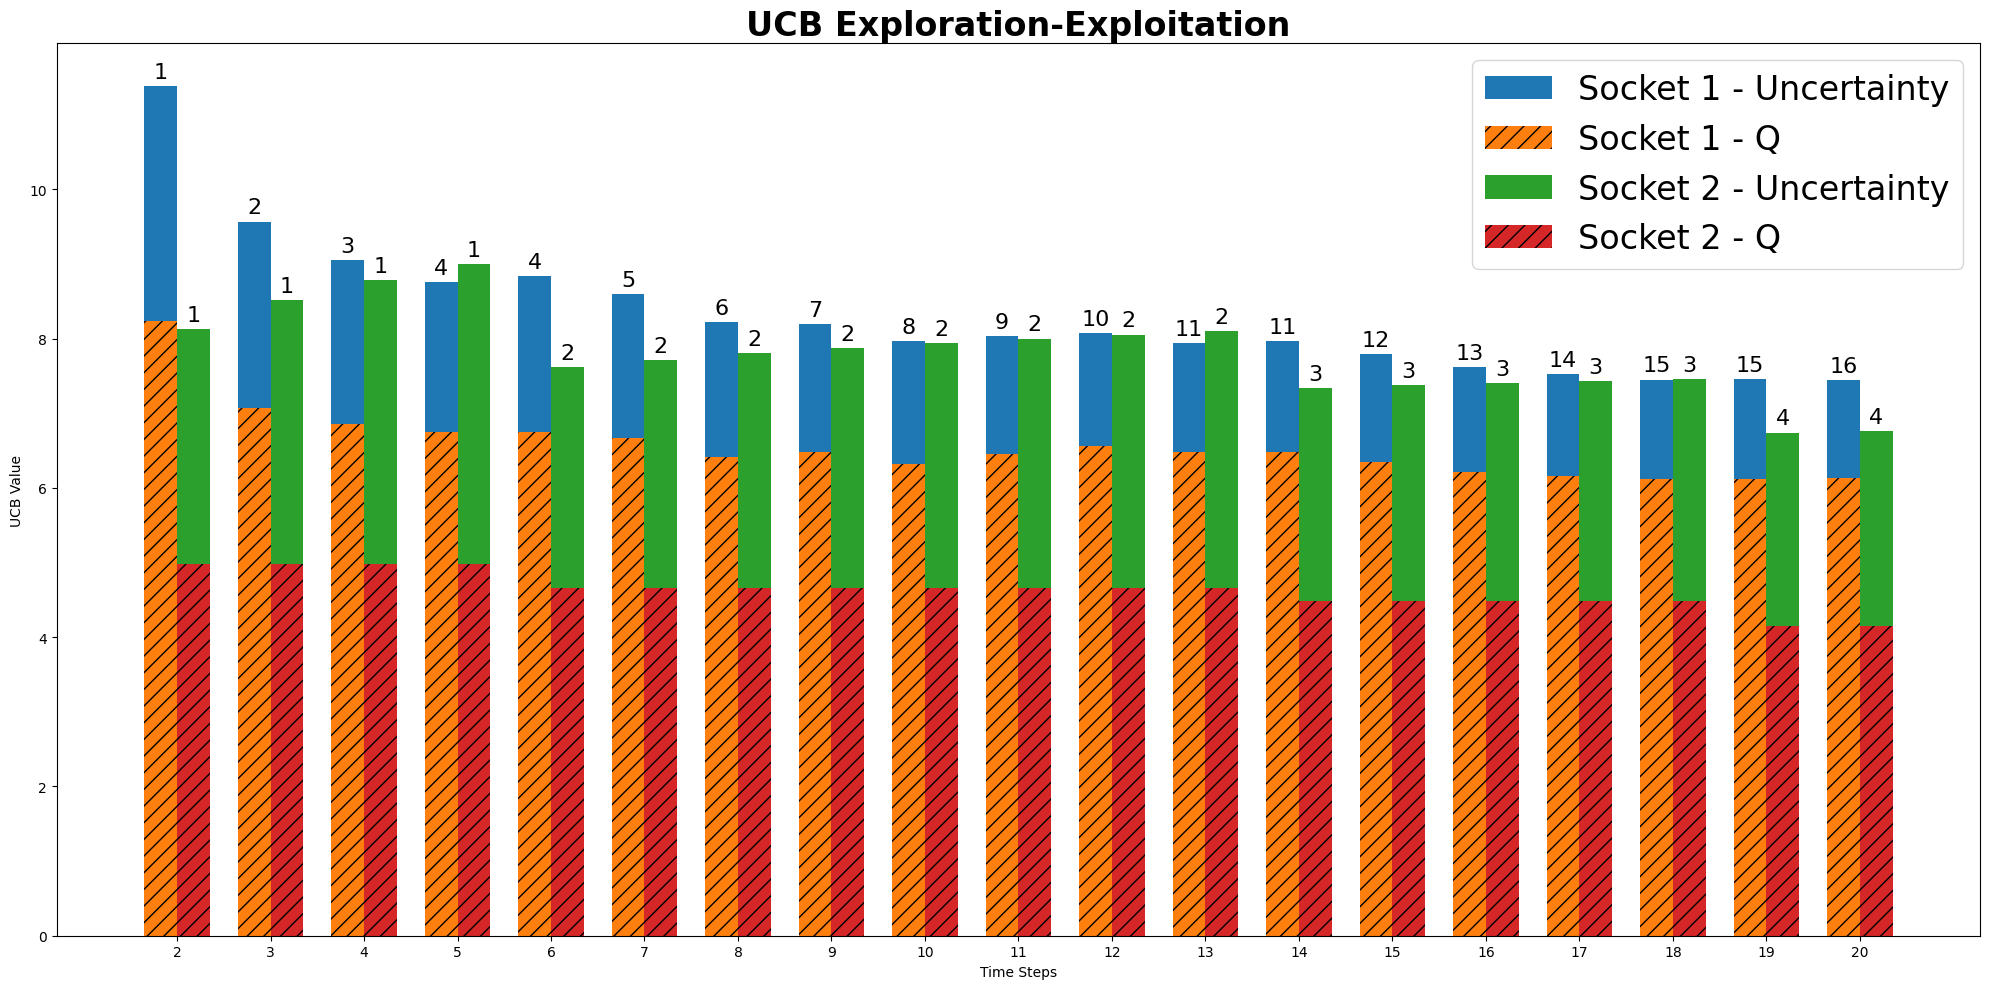

In [28]:
# get the parameters to graph from the socket stats
estimates = tester.socket_stats[:,:,0]
trials = tester.socket_stats[:,:,1]
uncertainty = tester.socket_stats[:,:,2]

# the label locations
# - start the examination after all sockets have been tried once
x = np.arange(len(estimates[:,0]))[2:]
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(20, 10))

rects1 = [ plt.bar(x, uncertainty[2:,0]+estimates[2:,0], align='edge', width= -width, label='Socket 1 - Uncertainty'),
           plt.bar(x, estimates[2:,0], align='edge', width= -width, label='Socket 1 - Q', hatch='//')]

rects2 = [ plt.bar(x, uncertainty[2:,1]+estimates[2:,1], align='edge',width= width, label='Socket 2 - Uncertainty'),
           plt.bar(x, estimates[2:,1], align='edge',width= width, label='Socket 2 - Q', hatch='//')]

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('UCB Value')
ax.set_xlabel('Time Steps')
ax.set_title('UCB Exploration-Exploitation', fontsize=24, fontweight='bold')
ax.legend(fontsize=24)
ax.set_xticks(x)


def autolabel(rects,index,trials):
    """Attach a text label above each bar in *rects*, displaying its number of trials"""

    for i,rect in enumerate(rects[0]):
        height = rect.get_height()
        ax.annotate('{:.0f}'.format(trials[i+2,index]),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    size=16,
                    ha='center', va='bottom')


autolabel(rects1,0,trials)
autolabel(rects2,1,trials)

fig.tight_layout()

# plt.savefig('ucb_exploration_exploitation.png')
plt.show()

### The confidence value 'c'

In [29]:
def plot_ucb_socket_percentages( confidence_values, socket_percentages, number_of_steps ):

    df = pd.DataFrame(socket_percentages)
    for socket in range(df.shape[1]):
        plt.plot(confidence_values, df[socket]*100, label = f'{socket+1}', marker='o', linestyle='--')

    plt.plot(confidence_values, np.ones(df.shape[0])*20,'k')

    plt.legend(title = 'Sockets')
    plt.title('Socket Selection Percentage vs Confidence Level', fontsize=15)
    plt.xlabel('Confidence Level')
    plt.ylabel('Socket Selection (%)')


def plot_ucb_reward_per_timestep( confidence_values, reward_per_timestep, number_of_steps, figsize=(10,8) ):

    plt.plot( confidence_values, reward_per_timestep, marker='o', linestyle='--', color='r')
    plt.title('Mean Total Reward per Time Step vs Confidence Level', fontsize=15)
    plt.xlabel('Confidence Level')
    plt.ylabel('Mean Total Reward per Time Step')


def plot_ucb(confidence_values, reward_per_timestep, optimal_selected, socket_percentages, final_socket_estimates, number_of_steps ):
    fig = plt.figure(figsize=(24,10))

    plt.suptitle(f'Upper Confidence Bound: {number_of_steps} time-steps per run', fontsize=20, fontweight='bold')

    plt.subplot(1, 2, 1)
    plot_ucb_socket_percentages( confidence_values, socket_percentages, number_of_steps )

    plt.subplot(1, 2, 2)
    plot_ucb_reward_per_timestep( confidence_values, reward_per_timestep, number_of_steps )

    plt.savefig(f"Images/ucb_{number_of_steps}.png")
    plt.show()

In [30]:
def ucb_experiment( number_of_tests, number_of_steps, confidence_level = 3.0):

    experiment = SocketExperiment(socket_tester   = UCBSocketTester( confidence_level = confidence_level ),
                                  number_of_tests = number_of_tests,
                                  number_of_steps = number_of_steps)
    experiment.run()

    return experiment.get_estimates(),\
           experiment.get_mean_total_reward(),\
           experiment.get_optimal_selected(),\
           experiment.get_socket_percentages()

In [31]:
def run_ucb_experiment( start, end, step = 0.01, number_of_tests = 100, number_of_steps = 300 ):

    test_values = []
    reward_per_timestep = []
    optimal_selected = []
    socket_percentages = []
    final_socket_estimates = []

    # iterate over the confidence level values
    for confidence_level in tqdm( np.arange( start, (end+step), step ) ):

        # save the test value used to run this test
        test_values.append( confidence_level )

        mean_estimates, mean_reward_per_timestep, mean_optimal_selected, mean_socket_percentage = ucb_experiment( number_of_tests, number_of_steps, confidence_level )

        reward_per_timestep.append( mean_reward_per_timestep )
        optimal_selected.append( mean_optimal_selected )
        socket_percentages.append( mean_socket_percentage )
        final_socket_estimates.append( mean_estimates[-1] )

    return test_values, reward_per_timestep, optimal_selected, socket_percentages, final_socket_estimates

In [32]:
# how many times each test should be run
number_of_tests = 500

# the confidence level test range
start = 0
stop = 100.0
step = 5

number_of_steps = 100
confidence_values, reward_per_timestep, optimal_selected, socket_percentages, final_socket_estimates = \
    run_ucb_experiment( start, stop, step, number_of_tests, number_of_steps )

100%|██████████| 21/21 [00:55<00:00,  2.64s/it]


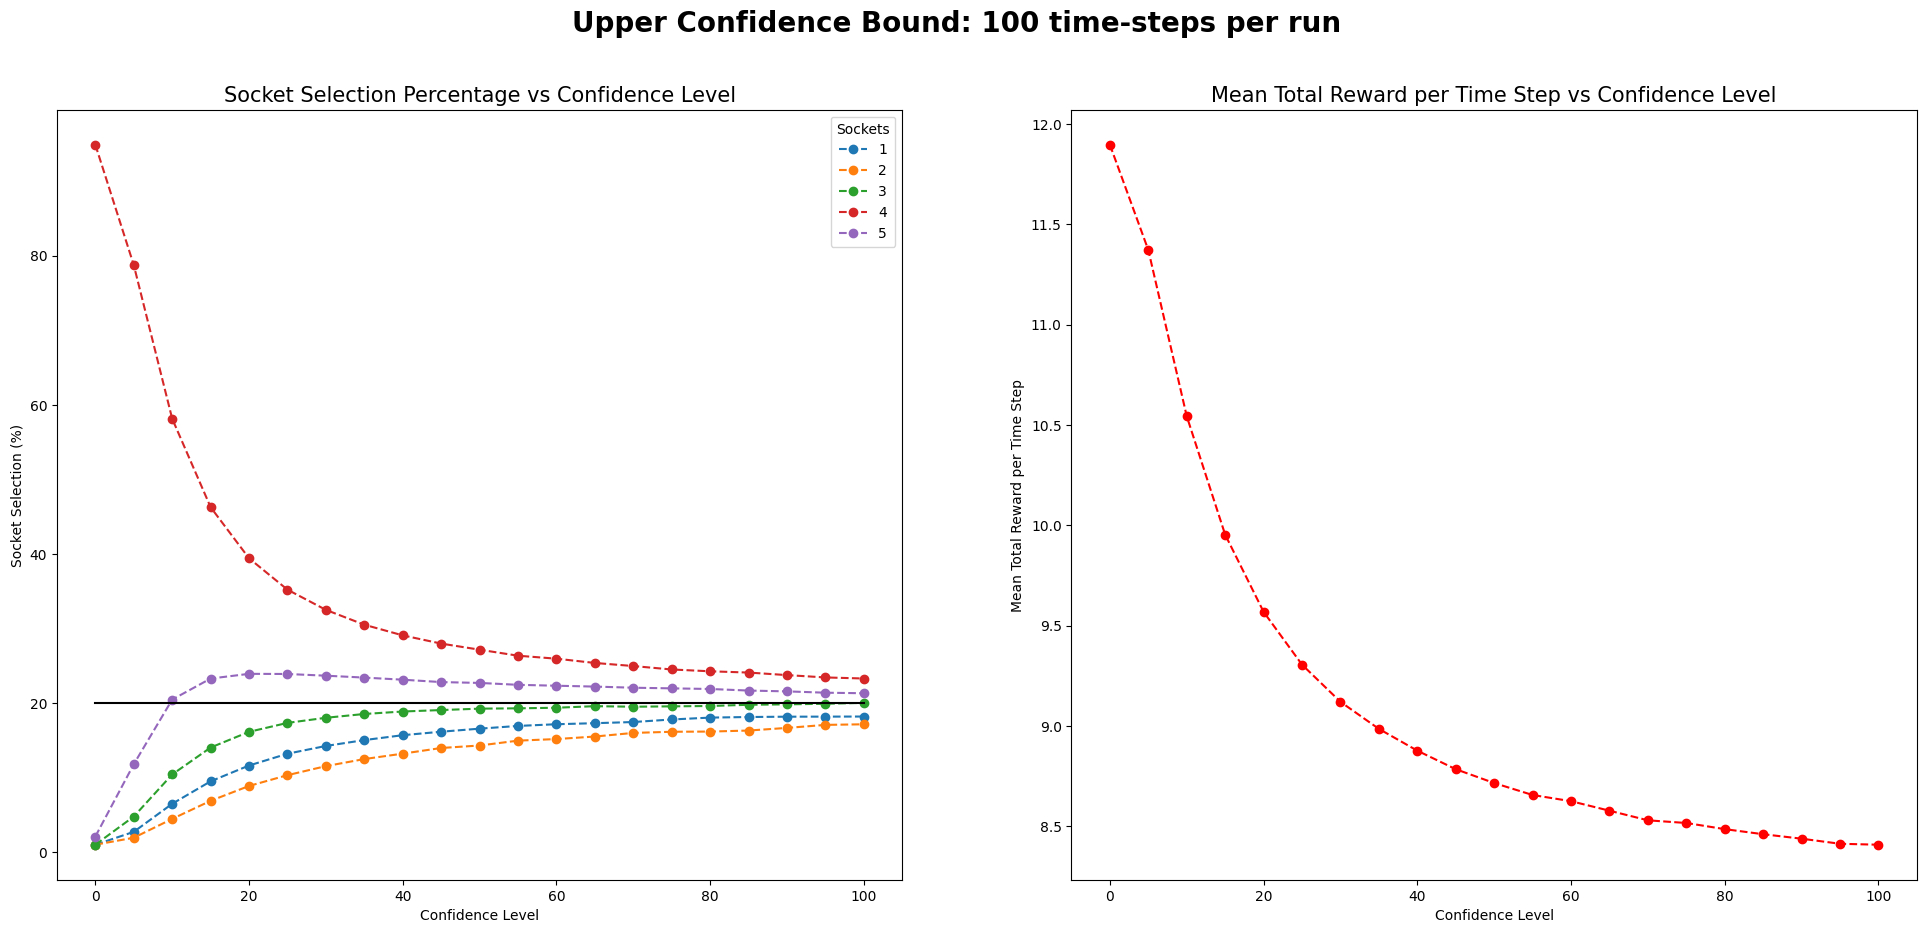

In [33]:
plot_ucb(confidence_values,
         reward_per_timestep,
         optimal_selected,
         socket_percentages,
         final_socket_estimates,
         number_of_steps )

In [34]:
# how many times each test should be run
number_of_tests = 1000

# the confidence level test range
start = 0.
stop = 2.0
step = 0.1

number_of_steps = 50
confidence_values, reward_per_timestep, optimal_selected, socket_percentages, final_socket_estimates = \
    run_ucb_experiment( start, stop, step, number_of_tests, number_of_steps )

100%|██████████| 21/21 [01:04<00:00,  3.08s/it]


Text(0, 0.5, 'Mean Total Reward per Time Step')

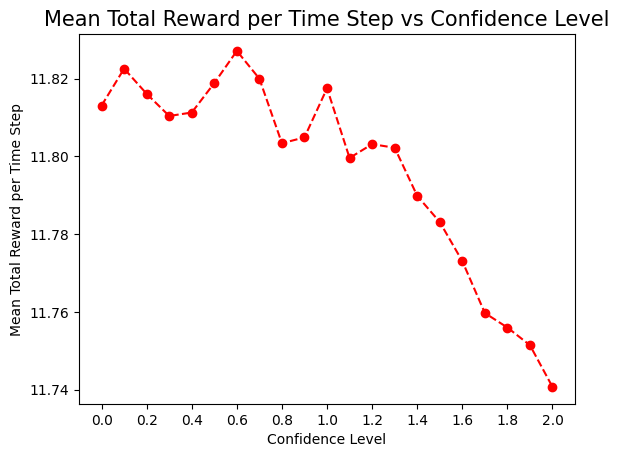

In [35]:
plt.xticks(np.arange(0., 2.2, 0.2))
plt.plot( confidence_values, reward_per_timestep, marker='o', linestyle='--', color='r')
plt.title('Mean Total Reward per Time Step vs Confidence Level', fontsize=15)
plt.xlabel('Confidence Level')
plt.ylabel('Mean Total Reward per Time Step')
#plt.savefig(f"Images/ucb_reward_per_timestep{number_of_steps}.png")

In [36]:
# create and test UCB sockets
tester = UCBSocketTester( confidence_level = 0.6)
tester.run( number_of_steps = 1000 )

print(f'Mean Reward per Time Step = {tester.get_mean_reward()}')
print(f'Optimal Socket Selected = {tester.get_optimal_socket_percentage()}')
print(f'Socket Percentages = {tester.get_socket_percentages()}')

Mean Reward per Time Step = 11.991760991046698
Optimal Socket Selected = 0.995995995995996
Socket Percentages = [0.001 0.001 0.001 0.996 0.001]


In [37]:
# run the test 100 times with each test running for 1000 timesteps
number_of_tests = 1000
number_of_steps = 1000

experiment = SocketExperiment(socket_tester   = UCBSocketTester( confidence_level = 0.6 ),
                              number_of_tests = number_of_tests,
                              number_of_steps = number_of_steps)
experiment.run()

Text(0, 0.5, 'Number of Trials')

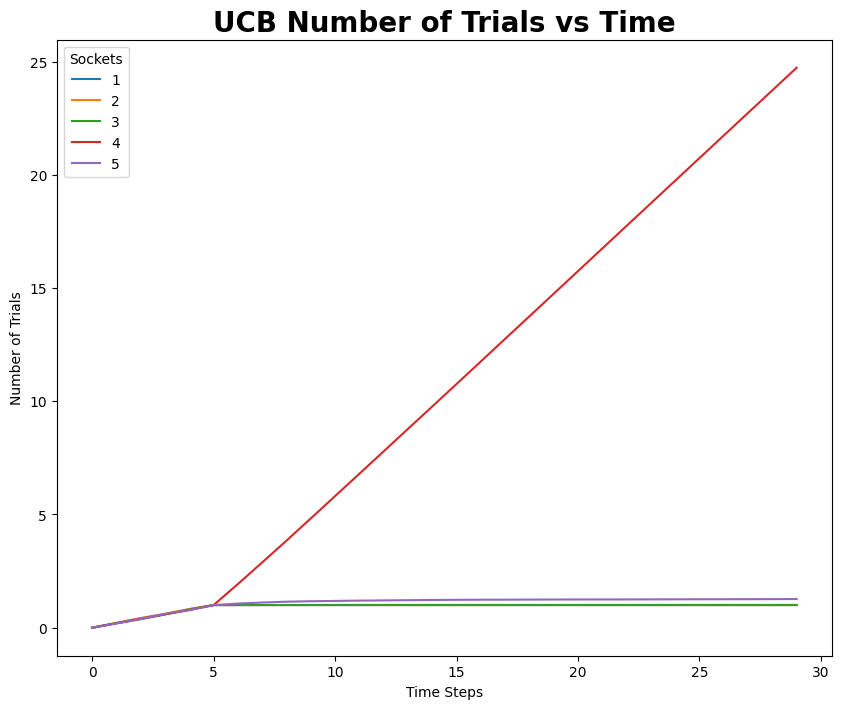

In [38]:
number_of_trials = experiment.get_number_of_trials()

plt.figure(figsize=(10,8))
for socket in range(number_of_trials.shape[1]):
    plt.plot(number_of_trials[:30,socket], label = f'{socket+1}')

plt.title('UCB Number of Trials vs Time', fontsize=20, fontweight='bold')
plt.legend(title = 'Sockets')
plt.xlabel('Time Steps')
plt.ylabel('Number of Trials')

#plt.savefig("Images/UCB_number_of_trials.png")

## UCB Regret

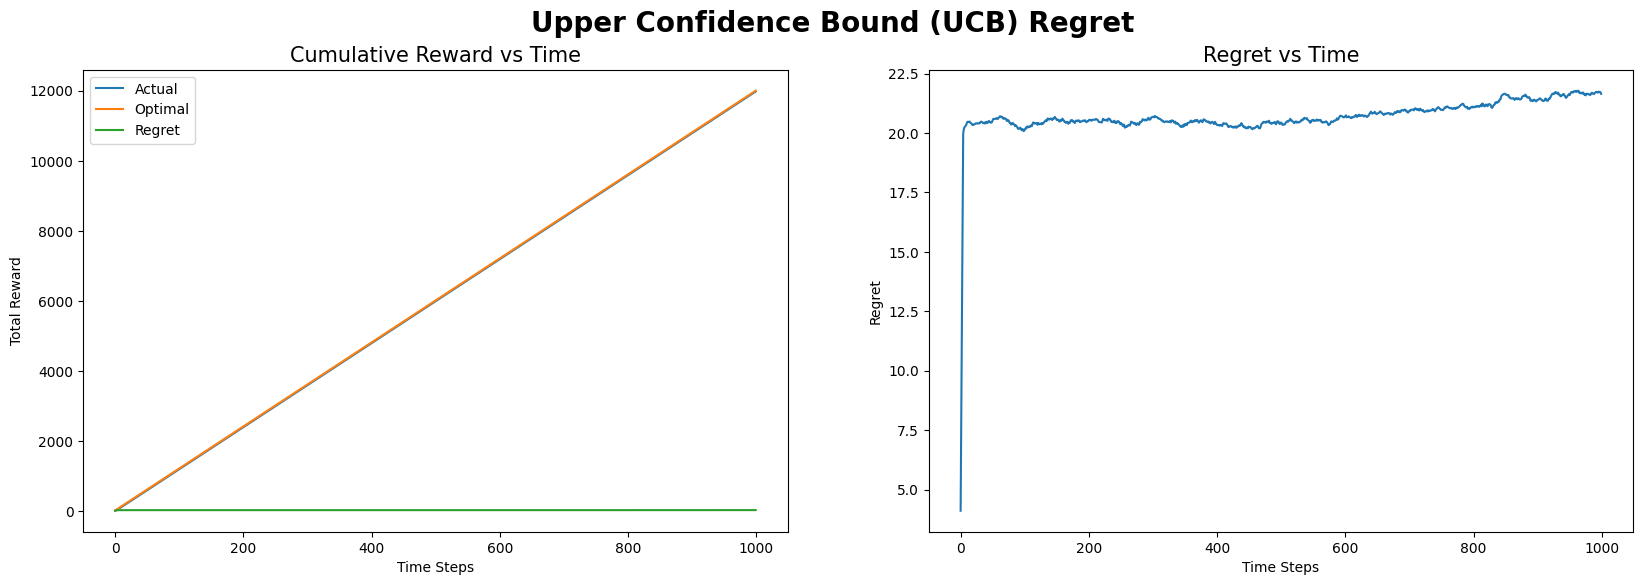

In [39]:
# best socket has a true mean reward of 12
cummulative_optimal_reward = [r*12 for r in range(1,number_of_steps+1)]

# regret is the difference between the optimal reward and the actual reward
regret = cummulative_optimal_reward - experiment.get_cumulative_reward_per_timestep()


fig = plt.figure(figsize=(20,6))
plt.suptitle(f'Upper Confidence Bound (UCB) Regret', fontsize=20, fontweight='bold')

plt.subplot(1, 2, 1)
plt.plot(experiment.get_cumulative_reward_per_timestep(),label = "Actual")
plt.plot(cummulative_optimal_reward, label ="Optimal")
plt.plot(regret, label ="Regret")
plt.legend()
plt.title('Cumulative Reward vs Time', fontsize=15)
plt.xlabel('Time Steps')
plt.ylabel('Total Reward')

plt.subplot(1, 2, 2)
plt.title('Regret vs Time', fontsize=15)
plt.plot(regret)
plt.xlabel('Time Steps')
plt.ylabel('Regret')

#plt.savefig(f"Images/ucb_regret.png")
plt.show()